In [226]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [227]:
# Read the two CSV files and concatenate them
df_historic = pd.read_csv('historic.csv')
# df_historic2 = pd.read_csv('historic2.csv')
# df_historic = pd.concat([df_historic1, df_historic2], ignore_index=True)

In [228]:
print(df_historic.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_client              60000 non-null  object 
 1   loan_date              60000 non-null  object 
 2   loan_due_date          60000 non-null  object 
 3   payment_date           60000 non-null  object 
 4   income                 60000 non-null  float64
 5   culture                60000 non-null  int64  
 6   hectar                 60000 non-null  float64
 7   total_hectares_client  60000 non-null  float64
 8   loan_amount            60000 non-null  float64
 9   loan_amount_term       60000 non-null  int64  
 10  rating                 60000 non-null  int64  
 11  score                  60000 non-null  int64  
 12  total_debt             60000 non-null  float64
 13  default_status         60000 non-null  int64  
 14  transaction_type       60000 non-null  object 
dtypes:

In [229]:
# Filter clients who have ever defaulted (default_status == 1)
clients_with_default = df_historic[df_historic['default_status'] == 1]['id_client'].unique()
df_historic[df_historic['id_client'].isin(clients_with_default)]

,id_client,loan_date,loan_due_date,payment_date,income,culture,hectar,total_hectares_client,loan_amount,loan_amount_term,rating,score,total_debt,default_status,transaction_type
0,CLIENT_0000,2022-06-02,2022-11-29,2022-11-26,96487.41,2,127.43,689.65,318575.0,180,3,673,318575.00,0,first
1,CLIENT_0000,2023-01-06,2024-01-01,2023-12-23,38281.19,5,173.54,689.65,312372.0,360,3,671,312372.00,0,historic
2,CLIENT_0000,2023-06-16,2024-06-10,2024-06-02,263554.57,3,175.59,689.65,351180.0,360,4,701,421831.59,0,historic
3,CLIENT_0000,2024-01-24,2025-01-18,2025-01-13,110105.68,6,264.42,689.65,396630.0,360,4,701,396630.00,0,historic
4,CLIENT_0000,2024-06-12,2024-12-09,2024-11-29,230461.80,1,267.77,689.65,803310.0,180,4,734,803310.00,0,historic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,CLIENT_5999,2023-06-08,2024-06-02,2024-05-25,466629.95,2,366.96,741.54,917400.0,360,0,200,1280630.13,0,historic
59996,CLIENT_5999,2024-06-17,2025-06-12,2025-09-16,314650.74,2,275.33,741.54,688325.0,360,0,230,864189.88,1,historic
59997,CLIENT_5999,2025-01-01,2025-06-30,2025-07-02,162832.59,5,343.32,741.54,617976.0,180,0,218,617976.00,1,historic
59998,CLIENT_5999,2025-06-17,2026-06-12,2026-06-03,297475.04,1,192.66,741.54,577980.0,360,0,200,708767.30,0,historic


In [230]:
# clear dataset to remove null data
df_credit_clear = df_historic.dropna()
# transform id_client to int
df_credit_clear['id_client'] = df_credit_clear['id_client'].str.replace('CLIENT_', '').astype(int)

In [231]:
# df_credit_clear.sort_values(by="rating", ascending=True).head()
df_credit_clear.describe()
# df_credit_clear['id_client']


,id_client,income,culture,hectar,total_hectares_client,loan_amount,loan_amount_term,rating,score,total_debt,default_status
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,6.000000e+04,60000.000000,60000.000000,60000.000000,6.000000e+04,60000.000000
mean,2996.931900,252611.135317,3.864150,145.321971,525.063540,3.264736e+05,270.492000,1.490550,450.025517,4.041940e+05,0.408983
std,1733.039806,143366.028783,1.739151,108.908267,276.908708,2.750402e+05,89.999405,1.808277,209.872522,3.039534e+05,0.491650
min,0.000000,5014.120000,1.000000,2.780000,50.230000,4.170000e+03,180.000000,0.000000,200.000000,5.936990e+03,0.000000
25%,1484.000000,128061.307500,2.000000,56.710000,285.720000,1.186740e+05,180.000000,0.000000,248.000000,1.635141e+05,0.000000
50%,2998.500000,253041.795000,4.000000,116.450000,523.170000,2.477025e+05,360.000000,1.000000,418.000000,3.293361e+05,0.000000
75%,4492.000000,377312.587500,5.000000,213.810000,769.170000,4.587152e+05,360.000000,3.000000,649.000000,5.786954e+05,1.000000
max,5999.000000,499995.510000,6.000000,497.120000,999.960000,1.739920e+06,360.000000,5.000000,850.000000,1.739920e+06,1.000000


In [258]:
# Convert date columns to datetime objects
date_cols = ['loan_date', 'loan_due_date', 'payment_date']
for col in date_cols:
    df_credit_clear[col] = pd.to_datetime(df_credit_clear[col])

# Calculate loan duration and days to payment
df_credit_clear['loan_duration_days'] = (df_credit_clear['loan_due_date'] - df_credit_clear['loan_date']).dt.days
df_credit_clear['days_to_payment'] = (df_credit_clear['payment_date'] - df_credit_clear['loan_due_date']).dt.days


In [259]:
# Select features for the Random Forest model
# Exclude original categorical columns, date columns, and id_client
features = [ 'id_client',
    'total_hectares_client', 'loan_amount',
    'loan_amount_term', 'rating', 'score', 'total_debt',
    'loan_duration_days', 'days_to_payment', 'culture'    
]

#Split dataset into features and target variable
dt_x = df_credit_clear[features]
dt_y = df_credit_clear['default_status']

In [260]:
#Split the dataset into temporary and testing sets
dt_x_temp, dt_x_test, dt_y_temp, dt_y_test = train_test_split(dt_x, dt_y, test_size=0.2)

In [261]:
dt_x_temp.count(), dt_y_temp.count(), dt_x_test.count(), dt_y_test.count()

(id_client                48000
 total_hectares_client    48000
 loan_amount              48000
 loan_amount_term         48000
 rating                   48000
 score                    48000
 total_debt               48000
 loan_duration_days       48000
 days_to_payment          48000
 culture                  48000
 dtype: int64,
 np.int64(48000),
 id_client                12000
 total_hectares_client    12000
 loan_amount              12000
 loan_amount_term         12000
 rating                   12000
 score                    12000
 total_debt               12000
 loan_duration_days       12000
 days_to_payment          12000
 culture                  12000
 dtype: int64,
 np.int64(12000))

In [262]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reducer', PCA()),
    ('classifier', RandomForestClassifier())])

pc = pipe.fit(dt_x_temp, dt_y_temp)

pc

,steps,"[('scaler', ...), ('reducer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'


In [263]:
y_pred = pipe.predict(dt_x_test)
accuracy_score(dt_y_test, y_pred)

0.98275

In [264]:
target_name = ['class 0','class 1']
print(classification_report(dt_y_test, y_pred, target_names=target_name))

              precision    recall  f1-score   support

     class 0       0.98      0.99      0.99      7069
     class 1       0.98      0.98      0.98      4931

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



Testes com o random search

In [265]:
max_depths_list = np.arange(1,101) # Odd numbers from 1 to 100

masx_features = np.linspace(0.001, 0.5, 100)

parameter_grid = {
    'max_depth': max_depths_list,
    'max_features': masx_features}

number_iterations = 10

grid = RandomizedSearchCV(estimator=RandomForestClassifier(),
                         param_distributions=parameter_grid,
                         scoring='precision',
                         n_iter=number_iterations,
                         return_train_score=True)

grid.fit(dt_x_temp, dt_y_temp)

C:\Users\cfreg\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\cfreg\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\cfreg\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

,estimator,RandomForestClassifier()
,param_distributions,"{'max_depth': array([ 1, ...98, 99, 100]), 'max_features': array([0.001 ..., 0.5 ])}"
,n_iter,10
,scoring,'precision'
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


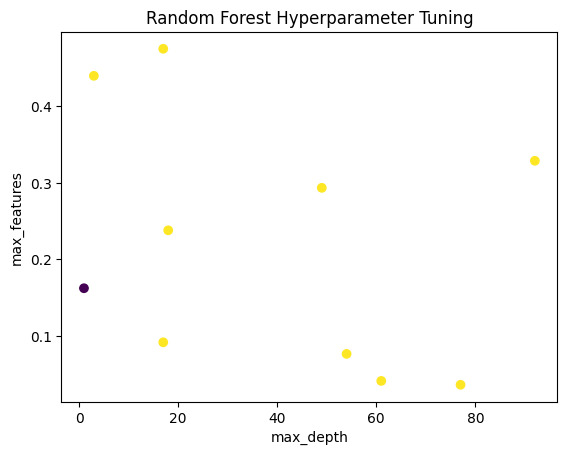

In [266]:
tested_x = list(grid.cv_results_['param_max_depth'])
tested_y = list(grid.cv_results_['param_max_features'])

plt.scatter(tested_x, tested_y, c=grid.cv_results_['mean_test_score'], cmap='viridis')
plt.gca().set(xlabel='max_depth', ylabel='max_features', title='Random Forest Hyperparameter Tuning')
plt.show()

In [267]:
grid.best_index_

np.int64(0)

In [268]:
grid.best_params_

{'max_features': np.float64(0.2378989898989899), 'max_depth': np.int64(18)}

In [269]:
grid.best_score_

np.float64(1.0)

In [270]:
predictions = grid.predict(dt_x_test)
print(precision_score(dt_y_test, predictions))

1.0


Test to validate models

In [271]:
#example to test hiperparameters on Random Forest
max_depths_list = [5,10]

In [272]:
hyperparameter_avg_metric = []
metric_log = []

In [273]:
for max_depth in max_depths_list:
    print(f"Testing max_depth: {max_depth}")
    # Create a Random Forest model with the current max_depth
    rf_model = RandomForestClassifier(max_depth=max_depth)
    
    model_metrics = []

    # Perform cross-validation
    kf = KFold(n_splits=10, shuffle=True)
    splits = kf.split(dt_x_temp)
    
    for train_index, validate_index in splits:
        X_train, X_validate = dt_x_temp.iloc[train_index], dt_x_temp.iloc[validate_index]
        y_train, y_validate = dt_y_temp.iloc[train_index], dt_y_temp.iloc[validate_index]

        # Fit the model
        rf_model.fit(X_train, y_train)

        # Predict on the validation set
        predictions = rf_model.predict(X_validate)

        # Calculate precision
        model_metrics.append( precision_score(y_validate, predictions))
        metric_log.append(precision_score(y_validate, predictions))

    hyperparameter_avg_metric.append(np.mean(model_metrics))

Testing max_depth: 5
Testing max_depth: 10


In [274]:
metric_log

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [275]:
hyperparameter_avg_metric

[np.float64(1.0), np.float64(1.0)]

In [ ]:
model = RandomForestClassifier()

cv_results = cross_val_score(model, dt_x_temp, dt_y_temp, cv=10, scoring='precision')
cv_results

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


--- Preprocessing ---

In [250]:
df_credit_clear.columns

Index(['id_client', 'loan_date', 'loan_due_date', 'payment_date', 'income',
       'culture', 'hectar', 'total_hectares_client', 'loan_amount',
       'loan_amount_term', 'rating', 'score', 'total_debt', 'default_status',
       'transaction_type', 'loan_duration_days', 'days_to_payment'],
      dtype='object')

In [251]:
df = df_credit_clear
# Target variable encoding: 'default_status' (0 or 1)
df['default_status'] = df['default_status'].astype(int)

# --- Prepare Data for Traditional ML (Latest Transaction per Client) ---
# Sort by client and loan_date to ensure we pick the latest transaction
df_sorted = df.sort_values(by=['id_client', 'loan_date'])

# Get the last (most recent) transaction for each client
# This assumes we want to predict the default status of the *next* loan based on the most recent historical data.
# If a client has multiple entries, we take the one with the latest `loan_date`.
latest_transactions = df_sorted.groupby('id_client').tail(1).reset_index(drop=True)

print("\nDataFrame with latest transaction per client:")
print(latest_transactions.head())
print(latest_transactions.info())



DataFrame with latest transaction per client:
   id_client  loan_date loan_due_date payment_date     income  culture  \
0          0 2032-01-26    2033-01-20   2033-01-18  466184.65        5   
1          1 2034-01-06    2035-01-01   2034-12-28  414955.74        5   
2          2 2027-06-27    2027-12-24   2027-12-17   92828.28        3   
3          3 2030-01-18    2031-01-13   2031-01-10  325836.89        5   
4          4 2028-06-13    2028-12-10   2029-02-15  164328.93        1   

   hectar  total_hectares_client  loan_amount  loan_amount_term  rating  \
0  292.01                 689.65     525618.0               360       4   
1   69.63                 224.88     125334.0               360       0   
2   53.55                 575.36     107100.0               180       1   
3   89.41                 216.21     160938.0               360       0   
4  104.07                 280.03     312210.0               180       0   

   score  total_debt  default_status transaction_type  lo

In [252]:
# Select features for the Random Forest model
# Exclude original categorical columns, date columns, and id_client
features = [ 'id_client',
    'total_hectares_client', 'loan_amount',
    'loan_amount_term', 'rating', 'score', 'total_debt',
    'loan_duration_days', 'days_to_payment', 'culture'
]

X = latest_transactions[features]
y = latest_transactions['default_status']

print(X)

      id_client  total_hectares_client  loan_amount  loan_amount_term  rating  \
0             0                 689.65     525618.0               360       4   
1             1                 224.88     125334.0               360       0   
2             2                 575.36     107100.0               180       1   
3             3                 216.21     160938.0               360       0   
4             4                 280.03     312210.0               180       0   
...         ...                    ...          ...               ...     ...   
5995       5995                 851.28     252555.0               180       1   
5996       5996                  82.16      55740.0               360       0   
5997       5997                 257.65     120615.0               360       0   
5998       5998                 426.64     184194.0               180       0   
5999       5999                 741.54     140955.0               180       0   

      score  total_debt  lo

In [253]:

# Standardize numerical features
# Fit scaler only on training data later, but for now, fit on X to get the transformation
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

# --- Train-Test Split (Client-wise) ---
# We still need to ensure that clients in the training set are not in the test set.
# Since `latest_transactions` already has one row per client, we can split directly.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Stratify to maintain class distribution

print(f"\nX_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (4800, 10), y_train shape: (4800,)
X_test shape: (1200, 10), y_test shape: (1200,)


C:\Users\cfreg\AppData\Local\Temp\ipykernel_14868\1106328005.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[features] = scaler.fit_transform(X[features])


In [254]:
# --- Build and Train the Random Forest Model ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # 'balanced' handles class imbalance
rf_model.fit(X_train, y_train)

# --- Evaluate the Model ---
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1] # Probability of the positive class (default)

print("\n--- Model Evaluation (Random Forest) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


--- Model Evaluation (Random Forest) ---
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       691
           1       1.00      1.00      1.00       509

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200




Confusion Matrix:
[[691   0]
 [  0 509]]


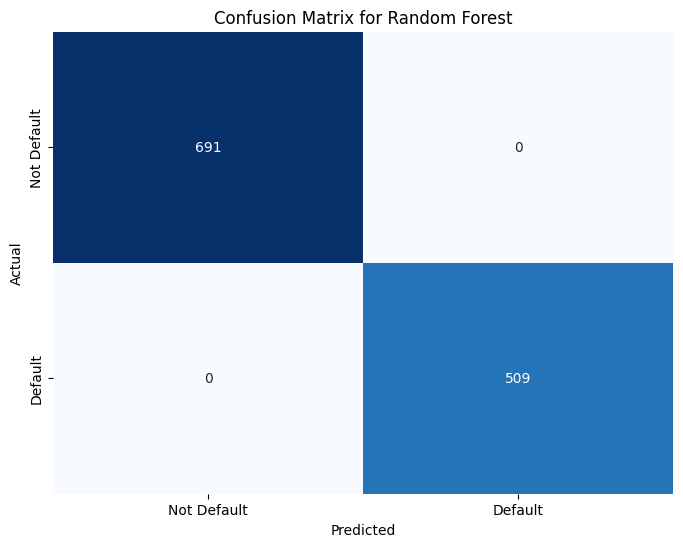

In [255]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()


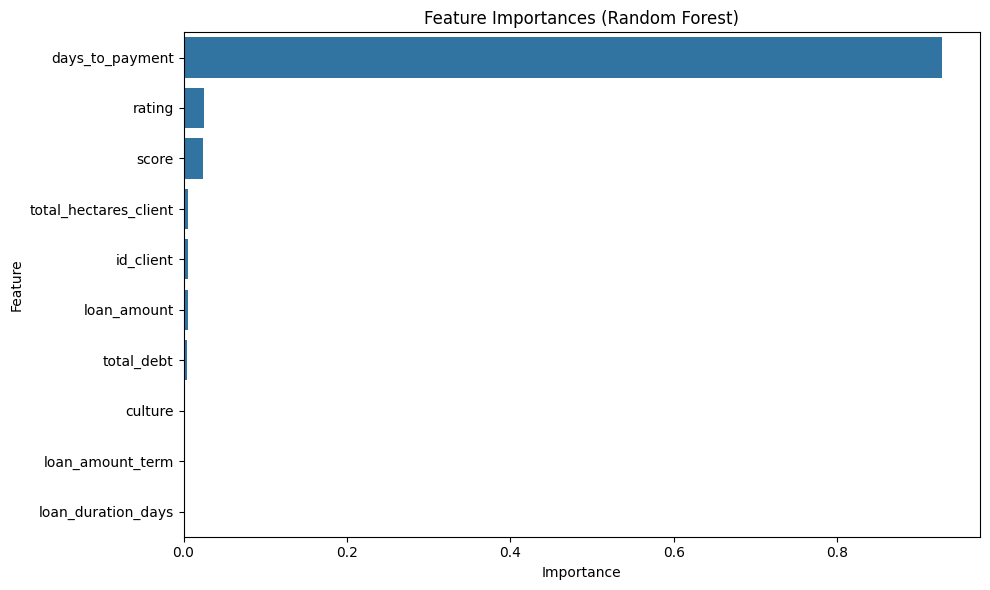

In [256]:
# --- Feature Importance ---
importances = rf_model.feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=forest_importances, y=forest_importances.index)
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [257]:

print("\n--- Next Steps ---")
print("This script successfully implemented a Random Forest Classifier to predict client loan default status.")
print("Key steps included:")
print("1. Data loading and initial cleaning.")
print("2. Feature engineering (loan duration, days to payment).")
print("3. Categorical feature encoding (LabelEncoder for 'culture', OneHotEncoder for 'transaction_type').")
print("4. Preparation of data by selecting the *latest* transaction for each client, suitable for traditional ML models.")
print("5. Numerical feature standardization.")
print("6. Client-wise train-test split to prevent data leakage.")
print("7. Random Forest model building, training, and evaluation.")
print("8. Visualization of Confusion Matrix and Feature Importances.")

print("\nFurther improvements and considerations:")
print("1. **Handling Imbalanced Data**: Although `class_weight='balanced'` was used, further techniques like SMOTE or different sampling strategies could be explored if the imbalance is severe.")
print("2. **Hyperparameter Tuning**: Optimize the Random Forest (e.g., `n_estimators`, `max_depth`, `min_samples_split`) using GridSearchCV or RandomizedSearchCV.")
print("3. **Cross-validation**: Implement k-fold cross-validation for more robust model evaluation.")
print("4. **Time-Series Features**: While this model uses the latest transaction, you could engineer more sophisticated time-series features (e.g., average income over last 3 loans, trend of total debt) if you want to capture more historical context for a non-sequential model.")
print("5. **Other Models**: Experiment with Gradient Boosting Machines (XGBoost, LightGBM) which often perform very well on tabular data.")
print("6. **Prediction for New Clients**: To predict for a new client, you would preprocess their latest transaction data in the same way (feature engineering, encoding, scaling) and then pass it to the trained `rf_model.predict()` or `rf_model.predict_proba()` method.")



--- Next Steps ---
This script successfully implemented a Random Forest Classifier to predict client loan default status.
Key steps included:
1. Data loading and initial cleaning.
2. Feature engineering (loan duration, days to payment).
3. Categorical feature encoding (LabelEncoder for 'culture', OneHotEncoder for 'transaction_type').
4. Preparation of data by selecting the *latest* transaction for each client, suitable for traditional ML models.
5. Numerical feature standardization.
6. Client-wise train-test split to prevent data leakage.
7. Random Forest model building, training, and evaluation.
8. Visualization of Confusion Matrix and Feature Importances.

Further improvements and considerations:
1. **Handling Imbalanced Data**: Although `class_weight='balanced'` was used, further techniques like SMOTE or different sampling strategies could be explored if the imbalance is severe.
2. **Hyperparameter Tuning**: Optimize the Random Forest (e.g., `n_estimators`, `max_depth`, `min_sampl